In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import numpy as np
import corr

sns.set_style("whitegrid")

## Outliers

In [6]:
df = pd.read_csv('../datasets_csv/merged_df_049depth.csv')
reduced = [ 'longitude', 'spco2',  'fe', 'omega_ca',  'no3', 'latitude'
            , 'month', 'year', 'dos', 'analysed_sst',  'fgco2','CHL']

df = df[reduced]
X = df.drop(columns='CHL')
y = df['CHL']

# Defining and throwing out outliers through percentile, Inter-quantile and z-values

threshold_per =  np.percentile(y, 99)
df_chl_filtered = df[df["CHL"] < threshold_per]
X_p = df_chl_filtered.drop('CHL', axis = 1)
y_p = df_chl_filtered[['CHL']]

df_chl_filtered = corr.drop_outliers(df, 'CHL')
X_i = df_chl_filtered.drop('CHL', axis = 1)
y_i = df_chl_filtered[['CHL']]

df_chl_filtered = corr.drop_outliers_z(df, 'CHL',3)
X_z = df_chl_filtered.drop(['CHL','Z_Score'], axis = 1)
y_z = df_chl_filtered[['CHL']]

## Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [8]:
# Train-test split
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_p, y_p, random_state = 1729)


X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_i, y_i, random_state = 1729)


X_z_train, X_z_test, y_z_train, y_z_test = train_test_split(X_z, y_z, random_state = 1729)
kfold = KFold(n_splits=5, shuffle=True)

## XgBoost

In [9]:
## import xgboost

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error

In [10]:
xgb_best_model = xgb.XGBRegressor(n_estimators = 5000, 
                          learning_rate = 0.1,
                          max_depth = 8,
                          verbosity = 0, 
                          random_state = 1729, 
                          early_stopping_rounds = 50,  
                          subsample = 0.8,  # Subsample ratio of the training instances
                          colsample_bytree = 0.9, 
                          device = 'cpu')
xgb_best_model.fit(X_p_train, y_p_train, eval_set = [ (X_p_test, y_p_test)], verbose = False)
rmse_p =xgb_best_model.evals_result()['validation_0']['rmse'][-1]

In [11]:
xgb_best_model = xgb.XGBRegressor(n_estimators = 5000, 
                          learning_rate = 0.1,
                          max_depth = 8,
                          verbosity = 0, 
                          random_state = 1729, 
                          early_stopping_rounds = 50,  
                          subsample = 0.8,  # Subsample ratio of the training instances
                          colsample_bytree = 0.9, 
                          device = 'cpu')
xgb_best_model.fit(X_i_train, y_i_train, eval_set = [ (X_i_test, y_i_test)], verbose = False)
rmse_i =xgb_best_model.evals_result()['validation_0']['rmse'][-1]

In [12]:
xgb_best_model = xgb.XGBRegressor(n_estimators = 5000, 
                          learning_rate = 0.1,
                          max_depth = 8,
                          verbosity = 0, 
                          random_state = 1729, 
                          early_stopping_rounds = 50,  
                          subsample = 0.8,  # Subsample ratio of the training instances
                          colsample_bytree = 0.9, 
                          device = 'cpu')
xgb_best_model.fit(X_z_train, y_z_train, eval_set = [ (X_z_test, y_z_test)], verbose = False)
rmse_z =xgb_best_model.evals_result()['validation_0']['rmse'][-1]

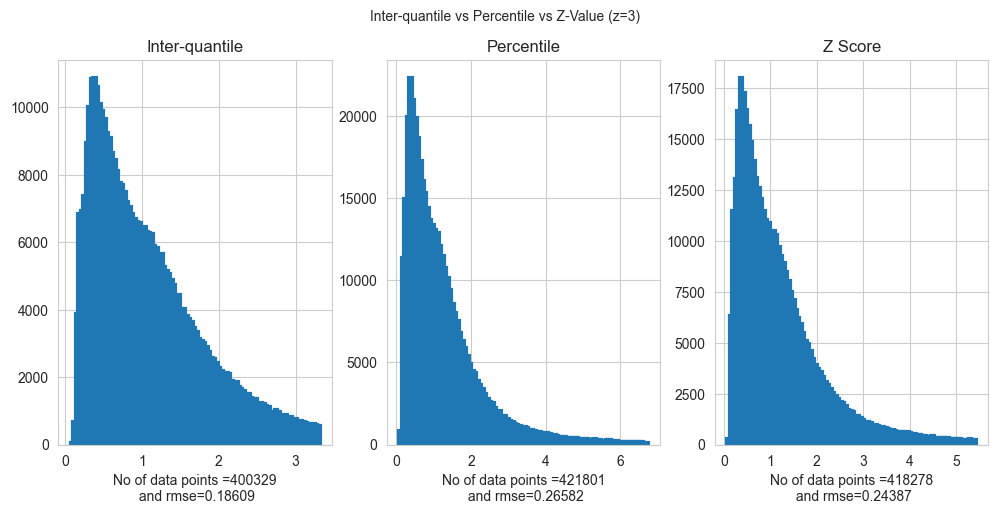

In [13]:
style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 3}
fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
fig.suptitle('Inter-quantile vs Percentile vs Z-Value (z=3)  ', size=10)

axes[0].hist(y_i, bins=100,**style)
axes[0].set_title("Inter-quantile")
axes[0].set_xlabel('No of data points =' +str(len(y_i)
                                              )+ '\n and rmse='+str(round(rmse_i,5)) )
axes[1].hist( y_p, bins=100,**style)
axes[1].set_title("Percentile")
axes[1].set_xlabel('No of data points =' +str(len(y_p)
                                              )+ '\n and rmse='+str(round(rmse_p,5)))
axes[2].hist(y_z, bins=100,**style)
axes[2].set_title("Z Score")
axes[2].set_xlabel('No of data points =' +str(len(y_z)
                                              )+ '\n and rmse='+str(round(rmse_z,5)))
plt.show()